<a href="https://colab.research.google.com/github/gmokyere/GPS_density_estimation/blob/main/taxi_gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [ ]:
# Downloaded on 3/15/2021 @10:50am EST
# https://privamov.github.io/accio/docs/datasets.html
# Tdrive part 6

def read_taxi_data(data, columns):
    df = pd.read_csv(data, header=None) # read data
    df.columns = columns #set column names

    if 'Date' in df.columns.to_list():
      df['Date'] = pd.to_datetime(df['Date'])

    return df # return a preview

columns = ['Taxi_id', 'Date', 'lon', 'lat']
df = read_taxi_data('39.txt', columns)   
df.head()

,Taxi_id,Date,lon,lat
0,39,2008-02-02 13:37:30,116.29369,39.92272
1,39,2008-02-02 13:40:17,116.28015,39.92321
2,39,2008-02-02 13:45:17,116.28065,39.92330
3,39,2008-02-02 13:45:17,116.28065,39.92330
4,39,2008-02-02 13:49:15,116.28012,39.92327


In [ ]:
df.shape

(1890, 4)

In [ ]:
df.dtypes

Taxi_id             int64
Date       datetime64[ns]
lon               float64
lat               float64
dtype: object

In [ ]:
## Check dates 

import statistics


2008-02-02 13:37:30
2008-02-08 17:35:25


## Exploratory Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


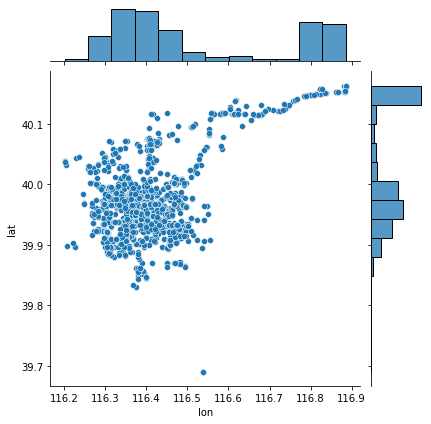

In [ ]:
## Check the cordinates covered
import seaborn as sns

sns.jointplot(df.lon, df.lat)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


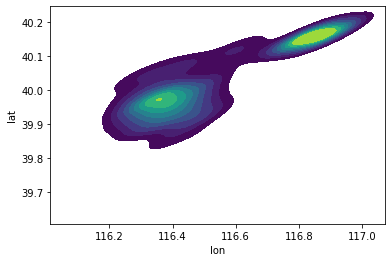

In [ ]:
sns.kdeplot(df.lon, df.lat, shade=True, cmap='viridis')

In [ ]:
## Map of taxi cordinates in Japan
import mplleaflet as mpll


rids = np.arange(df.shape[0])
np.random.shuffle(rids)
f, ax = plt.subplots(1, figsize=(6, 6))
df.iloc[rids[:1000], :].plot(kind='scatter', x='lon', y='lat', \
                      s=30, linewidth=0, ax=ax);
mpll.display(fig=f,)

# Calculate distance and then speed

Distance will be calculated as the difference between two gps cordinates

speed = Dist/Time

In [ ]:
## Drop same timestamp since the carry same info

#df.drop_duplicates(subset= ['lon', 'lat'], keep='last', inplace = True)

In [ ]:
## one row droped
df.head()

In [ ]:
## calculate distance b/n starting and ending cordinates
from geopy.distance import vincenty, distance

df['dist'] = 0
for idx in range(len(df)-1):
  d = vincenty((df.lat[idx] ,df.lon[idx] ), (df.lat[idx+1] ,df.lon[idx+1])).m

  ## add dist to dataframe
  df.dist[idx+1] = d





In [ ]:
df['time_diff'] = 0.001

for i in range(len(df) - 1):
  t = (df.Date[i+1] - df.Date[i]).total_seconds()
  #t.astype('timedelta64[m]') #convert ns date type to mins
  df.time_diff[i+1] = t 

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Taxi_id,Date,lon,lat,dist,time_diff
0,39,2008-02-02 13:37:30,116.29369,39.92272,0,0.001
1,39,2008-02-02 13:40:17,116.28015,39.92321,1158,167.000
2,39,2008-02-02 13:45:17,116.28065,39.92330,43,300.000
3,39,2008-02-02 13:45:17,116.28065,39.92330,0,0.000
4,39,2008-02-02 13:49:15,116.28012,39.92327,45,238.000


In [ ]:
## drop same timestamp or rows with zero time_diff before calculating speed
## this will help avoid nans
df.drop(df.index[[3]], inplace = True)

In [ ]:
# add 0.001 to avoid zero speed since we will take the log later
df['spd'] = df['dist']/(df['time_diff']/1) + 0.001 #meters/s
df

,Taxi_id,Date,lon,lat,dist,time_diff,spd
0,39,2008-02-02 13:37:30,116.29369,39.92272,0,0.001,0.001000
1,39,2008-02-02 13:40:17,116.28015,39.92321,1158,167.000,6.935132
2,39,2008-02-02 13:45:17,116.28065,39.92330,43,300.000,0.144333
4,39,2008-02-02 13:49:15,116.28012,39.92327,45,238.000,0.190076
5,39,2008-02-02 13:54:15,116.30334,39.92250,1986,300.000,6.621000
...,...,...,...,...,...,...,...
1885,39,2008-02-08 17:24:57,116.47738,39.93250,972,300.000,3.241000
1886,39,2008-02-08 17:25:25,116.47544,39.93244,165,28.000,5.893857
1887,39,2008-02-08 17:30:25,116.46692,39.92228,1342,300.000,4.474333
1888,39,2008-02-08 17:33:13,116.45615,39.92131,927,168.000,5.518857


In [ ]:
df['spd'].max()

2861.001

In [ ]:
df.isnull().sum()

Taxi_id       0
Date          0
lon           0
lat           0
dist          0
time_diff     0
spd          81
dtype: int64

In [ ]:
## Remove nas in speed
df.dropna(subset=['spd'], inplace=True)

## Check speed dist

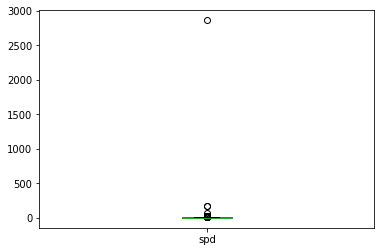

In [ ]:
df['spd'].plot(kind = 'box')

## Remove outliers


In [ ]:
from scipy.stats import zscore 

z = zscore(df['spd'])
z_abs = np.abs(z)

filtered_spd = (z_abs < 3)
df2 = df[filtered_spd]

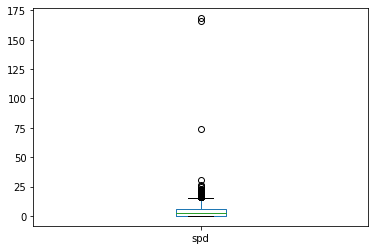

In [ ]:
df2['spd'].plot(kind = 'box')

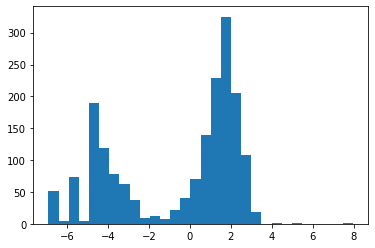

In [ ]:
## take the log of the data to respond to skewness

plt.hist(np.log(df.spd), bins=30)
plt.show()

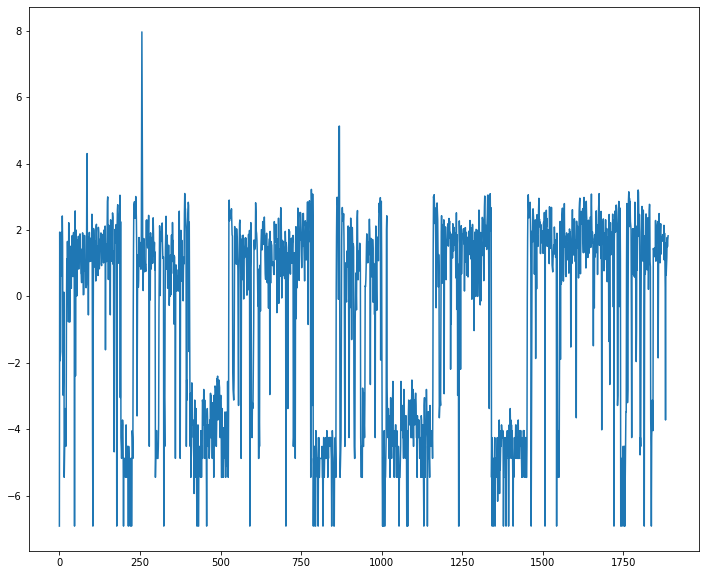

In [ ]:
fig = plt.figure(1, figsize=(12, 10))
plt.plot(np.log(df.spd))
plt.show()

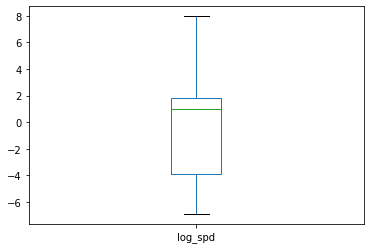

In [ ]:
df['log_spd'] = np.log(df.spd)
df['log_spd'].plot(kind='box')

In [ ]:
## save clean data

df.to_csv('taxi_39.csv')

# Wavelet

We can use the wavelet toolbox to denoise the dataset

In [ ]:
## Signal shoulb be an array for wavelet
signal = df['log_spd'].values
signal

array([-6.90775528,  1.93660005, -1.93562984, ...,  1.49835736,
        1.7081708 ,  1.82544332])

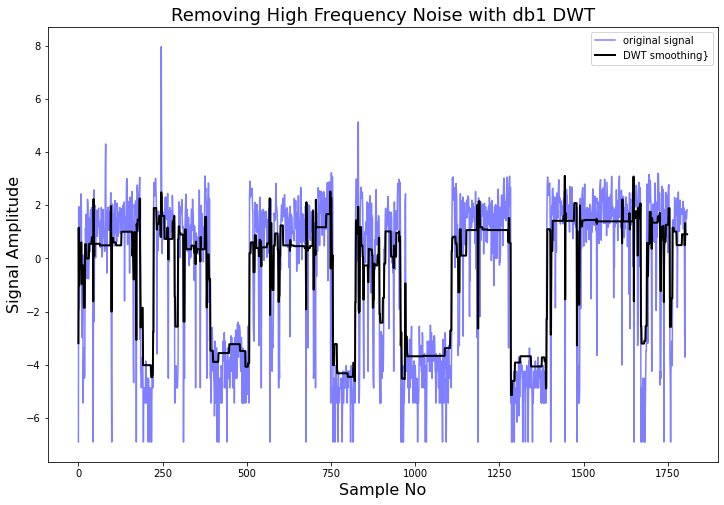

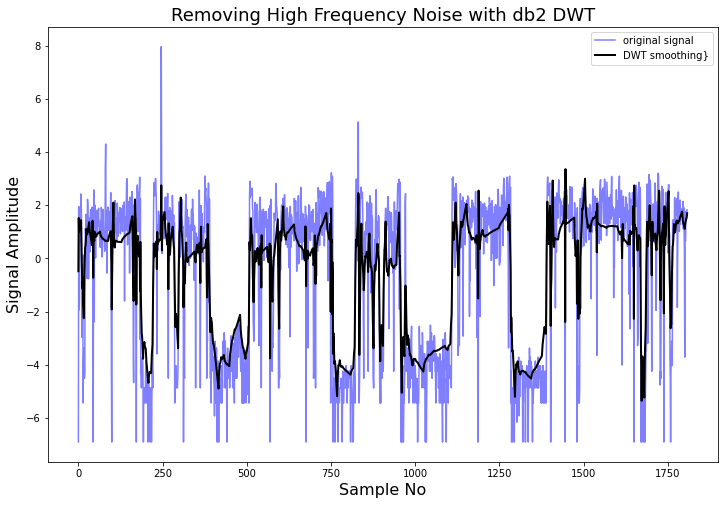

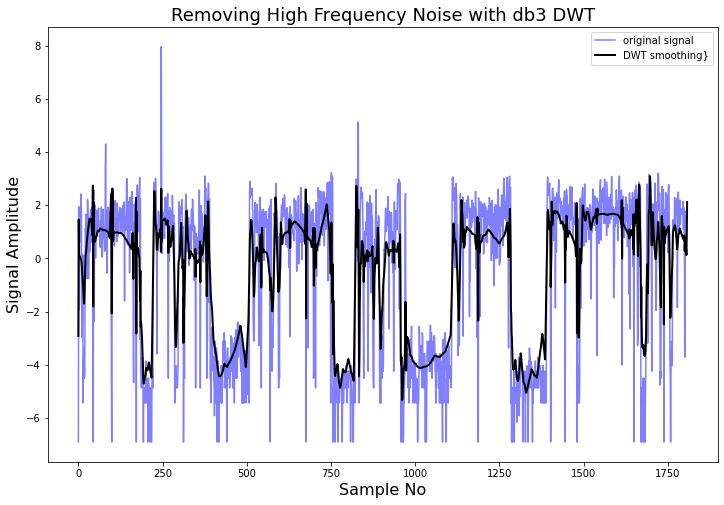

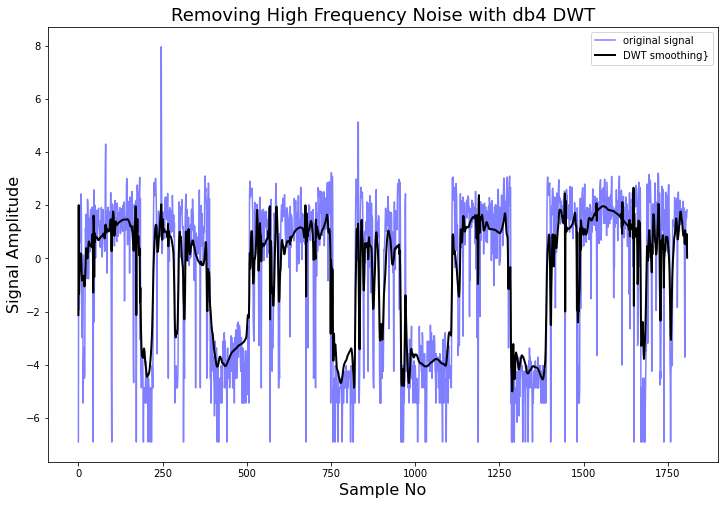

In [ ]:
import pywt
import time
from datetime import timedelta


def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

wav = ["db1","db2","db3","db4"]
wav2= ['db2']

for wav in wav:
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(signal, color="b", alpha=0.5, label='original signal')
    rec = lowpassfilter(signal, 0.4, wavelet = wav)
    ax.plot(rec, 'k', label='DWT smoothing}', linewidth=2)
    ax.legend()
    ax.set_title(f'Removing High Frequency Noise with {wav} DWT', fontsize=18)
    ax.set_ylabel('Signal Amplitude', fontsize=16)
    ax.set_xlabel('Sample No', fontsize=16)
    plt.show()

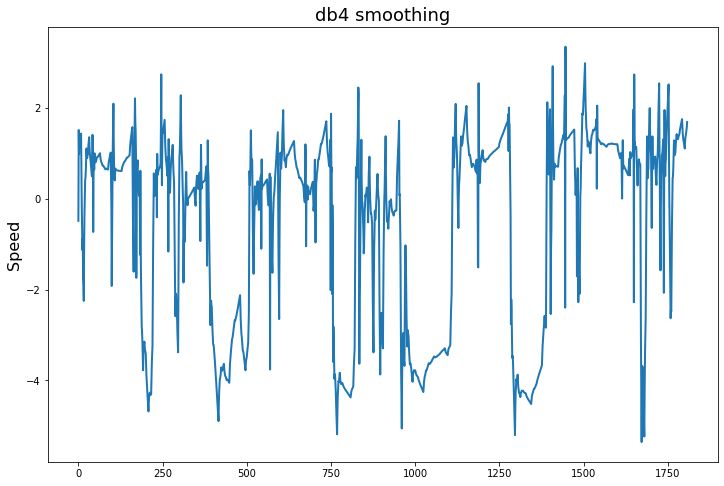

In [ ]:
coeff = pywt.wavedec(signal, 'sym2', mode="per" )
coeff[1:] = (pywt.threshold(i, value=.5, mode="soft" ) for i in coeff[1:])
reconstructed_signal = pywt.waverec(coeff, 'sym4', mode="per" )
reconstructed_signal

## GOF

In [ ]:
import re
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
#warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform', 'gamma', 'expon',   
              'lognorm','pearson3', 'triang']


def standarise(column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std = sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y              

In [ ]:
def fit_distribution2(column,pct,pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std,size,y_org = standarise(column,pct,pct_lower)
    dist_names = ['weibull_min','norm','weibull_max','beta', 'genextreme',
                 'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_org, percentile_bins)
    observed_frequency, bins = (np.histogram(y_org, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_org)
        print("{}\n{}\n".format(dist, param))
      

        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_expected_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [ ]:
df['spd_denoised'] = rec


ValueError: ignored

In [ ]:
fit_distribution2('spd',1,0)

(0.5340109066551294, 0.0009999999999999998, 2.6922981204062646)

(24.20916597915422, 709.350835105773)

(0.08359738321222204, 29209.001000000004, 1.7500786807025515)



/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(0.21165790058520406, 2861.539773346816, 0.0009999999999999998, 82567.79482786858)

(-1.0662328455811751, 0.20382113463153226, 0.3505736330637501)

(424.81291525940304, -0.010657921787196073, 0.0570129594268934)

(0.001, 29209.0)

(0.003911966740557158, 0.0009999999999999998, 17388.797335639207)

(0.001, 24.20816597915422)

(6.28754311459539, 0.000999999999999069, 3.985600919280029)

(2.503719989087454, 14.18500682133473, 17.756390701964285)

(5.283441741109514e-05, -2.7856075202142616, 29577.215467514063)


Distributions listed by Betterment of fit:
............................................
   Distribution    chi_square
3          beta  2.010000e+02
5      invgauss  7.270000e+02
9       lognorm  1.005000e+03
0   weibull_min  1.993000e+03
4    genextreme  6.284000e+03
10     pearson3  2.360600e+04
7         gamma  2.521300e+04
8         expon  3.504160e+05
1          norm  2.657373e+07
11       triang  2.210084e+08
6       uniform  4.365087e+08
2   weibull_max  2.206985e+10
